# **Session 3: Foundations of Machine Learning - Part Three**
This session continues the introduction of the foundations of machine learning. Specifically it will outline the fundamental concepts needed to gain intuition into how to make neural networks generalize.


---


In [ ]:
# --- set up our imports for this session ---
import torch
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive
import ipywidgets as widgets

## **Generalization**


Generalization is the ability to accurately predict unseen data instances. Models with a larger number of parameters (higher complexity) require more data in order to generalize, otherwise they will overfit to the data.

***The generalization error is the error of the test dataset.***

### **How to Tell When Overfitting has Occurred**

- When a model is trained on different datasets, the same test instance produces very different results.
- The loss or error between the training and test instances is large.



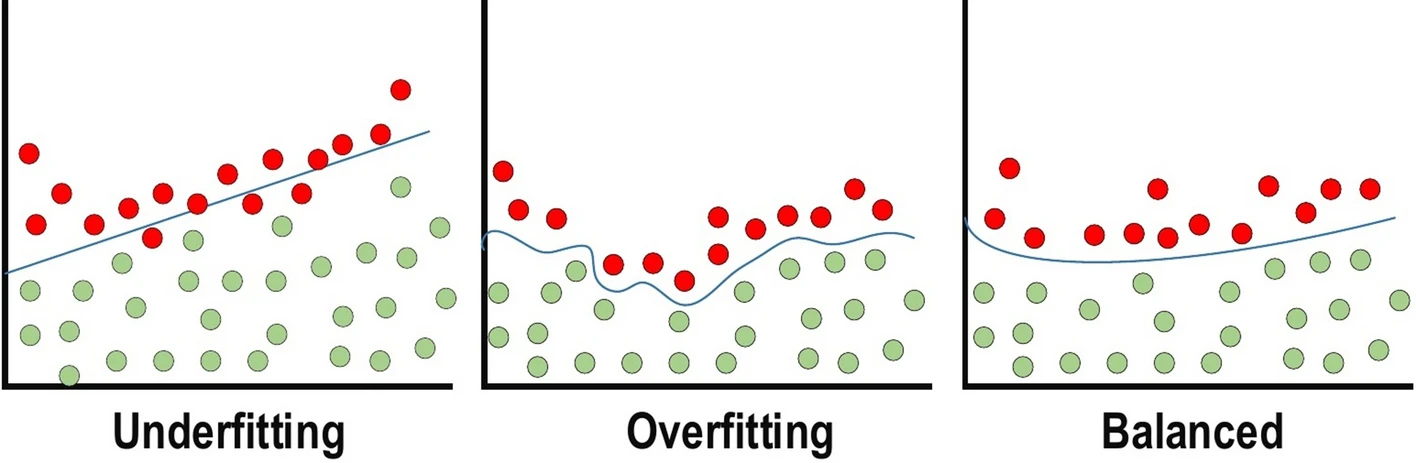

### **Data**

As a rough rule of thumb, your model should train on at ***least an order of magnitude*** more examples than trainable parameters.

#### ***Dataset Separation***
The dataset is to be separated into three distinct datasets, each with a specific purpose:


- **Training set**
  - Used to build the model, learn the parameters during training.
- **Validation set**
  - Used for model selection, hyperparameter tuning, and early stopping.
- **Test set**
  - Used to test the accuracy of the final, tuned model. The test set should never ever be used to make decisions about or to aid in training the model.


The number of data instances for each category is application specific but one can start with 85% for training data, 5% for validation and 10% for testing.


#### ***Hold-out and Cross Validation***
Hold-out and cross validation are methods to separate a dataset into subsets.


- **Hold-out**
  - Simply uses a fraction of the instances to train and model and the other portion is allocated for validation and testing.
- **Cross Validation and K-fold**
  - Splits the data into k segments, then for each of the segments a model is trained on the other k-1 segments and tested on the chosen segment.
  - This produces k different models and the average accuracy is taken over all of them.


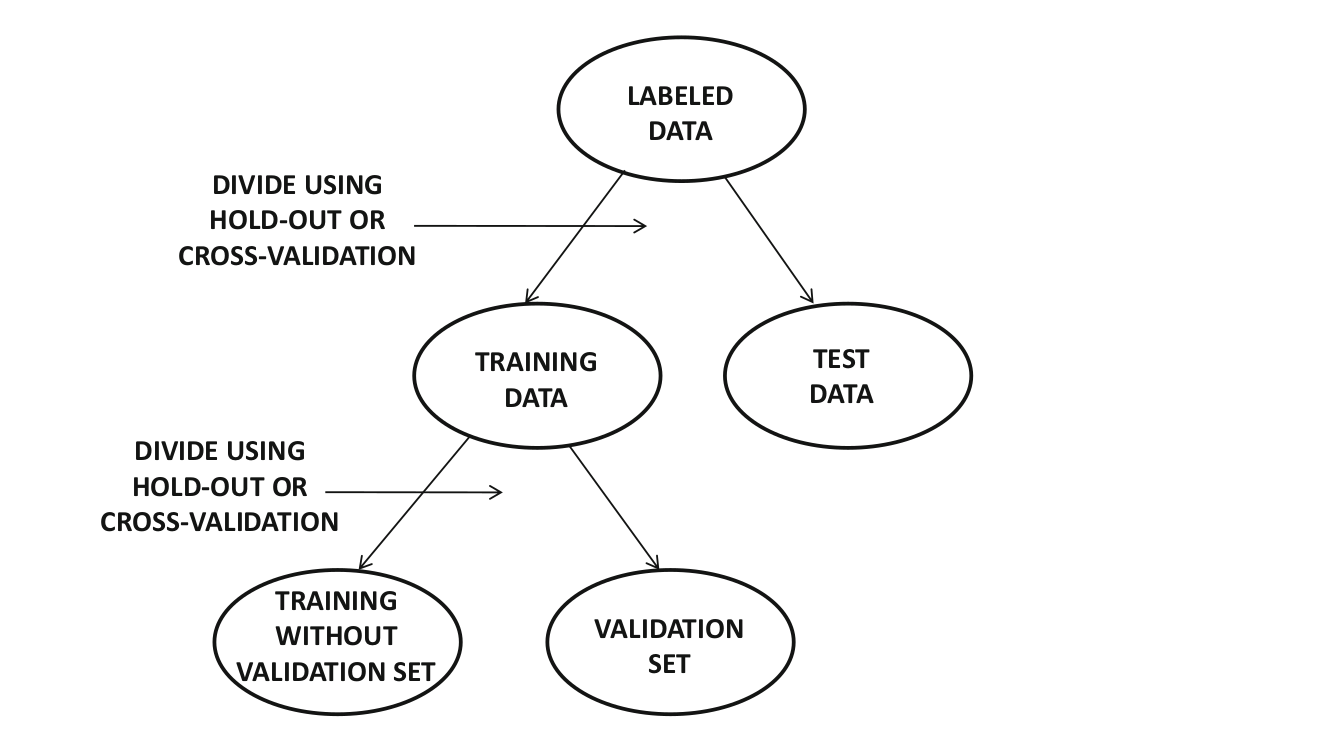

### **Bias-Variance Tradeoff**
When discussing squared error of a model, it can be mathematically broken down into three components:
- **Bias (Underfitting)**
  - The error caused by simplifying assumptions in the model, which causes certain test instances to have consistent errors across different choices of training data.
  - This error term tells us how far off the model's average prediction is.
  - The fewer the parameters the more biased error the model is likely to have.
- **Variance (Overfitting)**
  - The inability to learn all parameters of the model in a statistically robust manner, especially when limited training data is available and the model has a large number of parameters.
  - This error term tells us about the variability in its predictions as a result of the choice of training set.
- **Noise**
  -  The noise caused by inherent error in the data which is uncontrollable.

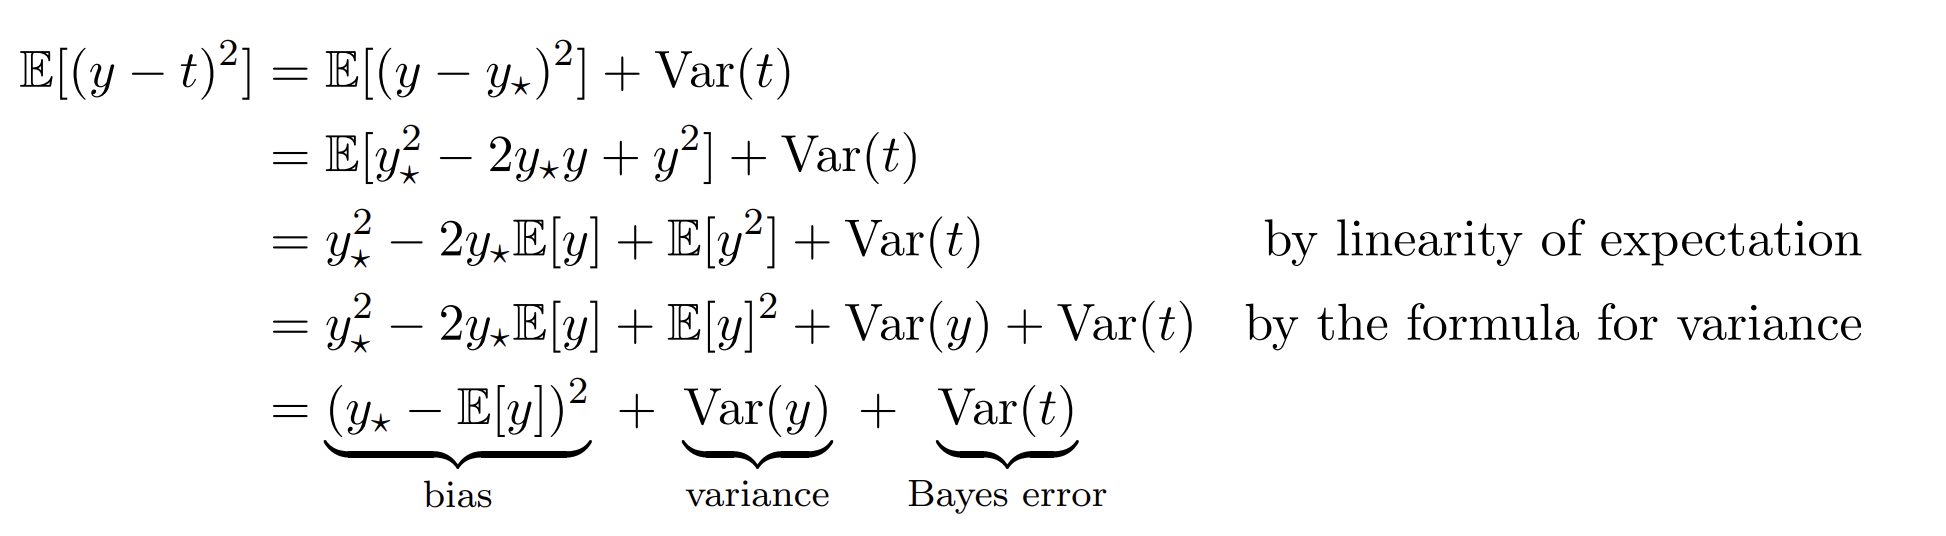

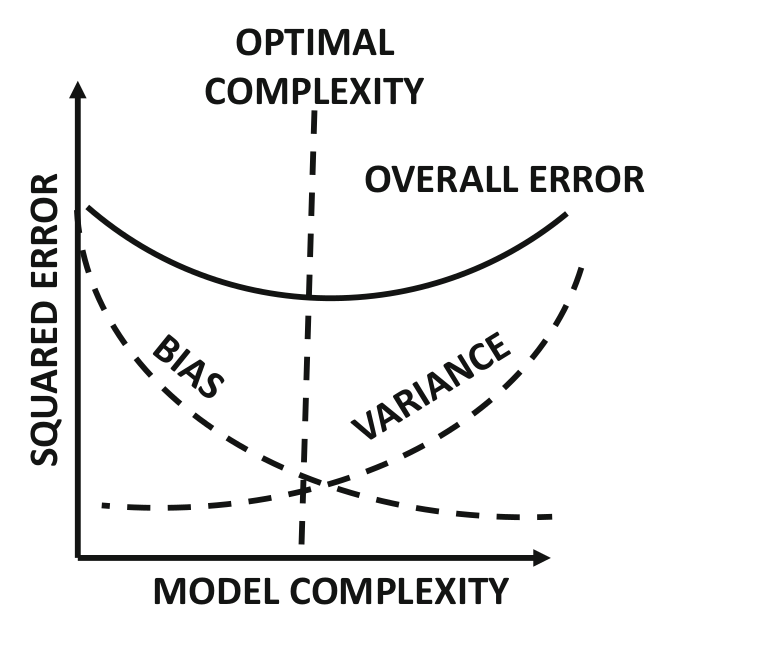

### ***How to Prevent Overfitting***
There are several methods that can be employed to prevent overfitting:
- Penalty based regularization
  - Apply a constraint /penalty on the learning parameters in order to favor simpler models
- Generic and tailored ensemble models
- Early stopping
  - The iterative optimization is terminated early before reaching the optimal solution on the training data
  - The error on the held-out data is used to determine when to stop training.
- Pretraining
  - The weights in different layers are sequentially trained using a greedy algorithm to find a good initialization.
- Continuation and curriculum training methods
  - First train simple models then make them more complex.
- Sharing Parameters

## **Penalty Based Regularization**

Penalty based regularization takes the form of

$ L_{ℛ} = L(\theta, D) + ℛ(\theta)$

where $ℛ$ is the regularizer that is only a function of the model parameters.



### **L2 Regularization (Weight Decay)**
The L2 regularization or Tikhonov regularization uses the L2-norm to penalize the parameters.

$ ℛ_{L2} = \lambda \sum_i^d \theta_i^2$

- This causes the distribution of values to be more spread out across all parameters rather than concentrating the activating values on a small subset of the parameters.
- As a result the average parameter values reduce and therefore is also known as weight decay.






### **L1 Regularization (Feature Selection)**
The L1 regularization uses the L1-norm to penalize the parameters.

$ ℛ_{L1} = \lambda \sum_i^d |\theta_i|$

- This induces a sparse representation in the parameters, causing some parameters to be set to zero if they do not contribute enough to the outputs.



---
A custom implementation of penality regularization is shown below.

In [ ]:

def penalty_regularization(model: torch.nn.Module,
                           penalty_lambda: float,
                           norm,
                           dtype=None,
                           device=None) -> torch.Tensor:
    """Performs a norm based penalty regularization on the parameters in the model.

    Args:
        model: The model to extract the parameters from.
        penalty_lambda: The multiplicative factor to apply to the regularization term.
        norm: The type of norm to use (i.e. 1, 2).
        dtype: The type to use for the regularization term.
        device: The device to use for the regularization term.

    Returns:
        torch.Tensor:
            The regularization term for the loss function.
    """
    regularization = torch.tensor(0., dtype=dtype, device=device, requires_grad=True)
    for name, parameter in model.named_parameters():
        if 'bias' not in name:
            regularization = regularization + torch.norm(parameter, p=norm)

    return penalty_lambda * regularization



---


Additionally, we can perform enable L2 regularization using the pytorch Adam optimizer. Here the parameter `weight_decay` is the $\lambda$ in the L2 regularization equation.

In [ ]:
torch.optim.Adam(torch.nn.Linear(1,1).parameters(), weight_decay=0.6)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.6
)

## **Ensemble Models**

The main idea behind ensemble models is that the average of a set of simpler models can produce a higher accuracy with a lower amount of variance.

There are several ways to generate and use ensemble models:
- Train on random subsets of the full training data. This procedure is
known as bagging.
- Train networks with different architectures (e.g. different numbers of
layers or units, or different choice of activation function).
- Use entirely different models or learning algorithms

### **Dropout**
Dropout uses node sampling to randomly drop connections between different layers during training. This causes an implicit effect of training different simpler models. It ensures that nodes are equally distributed in terms of the activating values. During test time all nodes are used and therefore acts as an ensemble model.

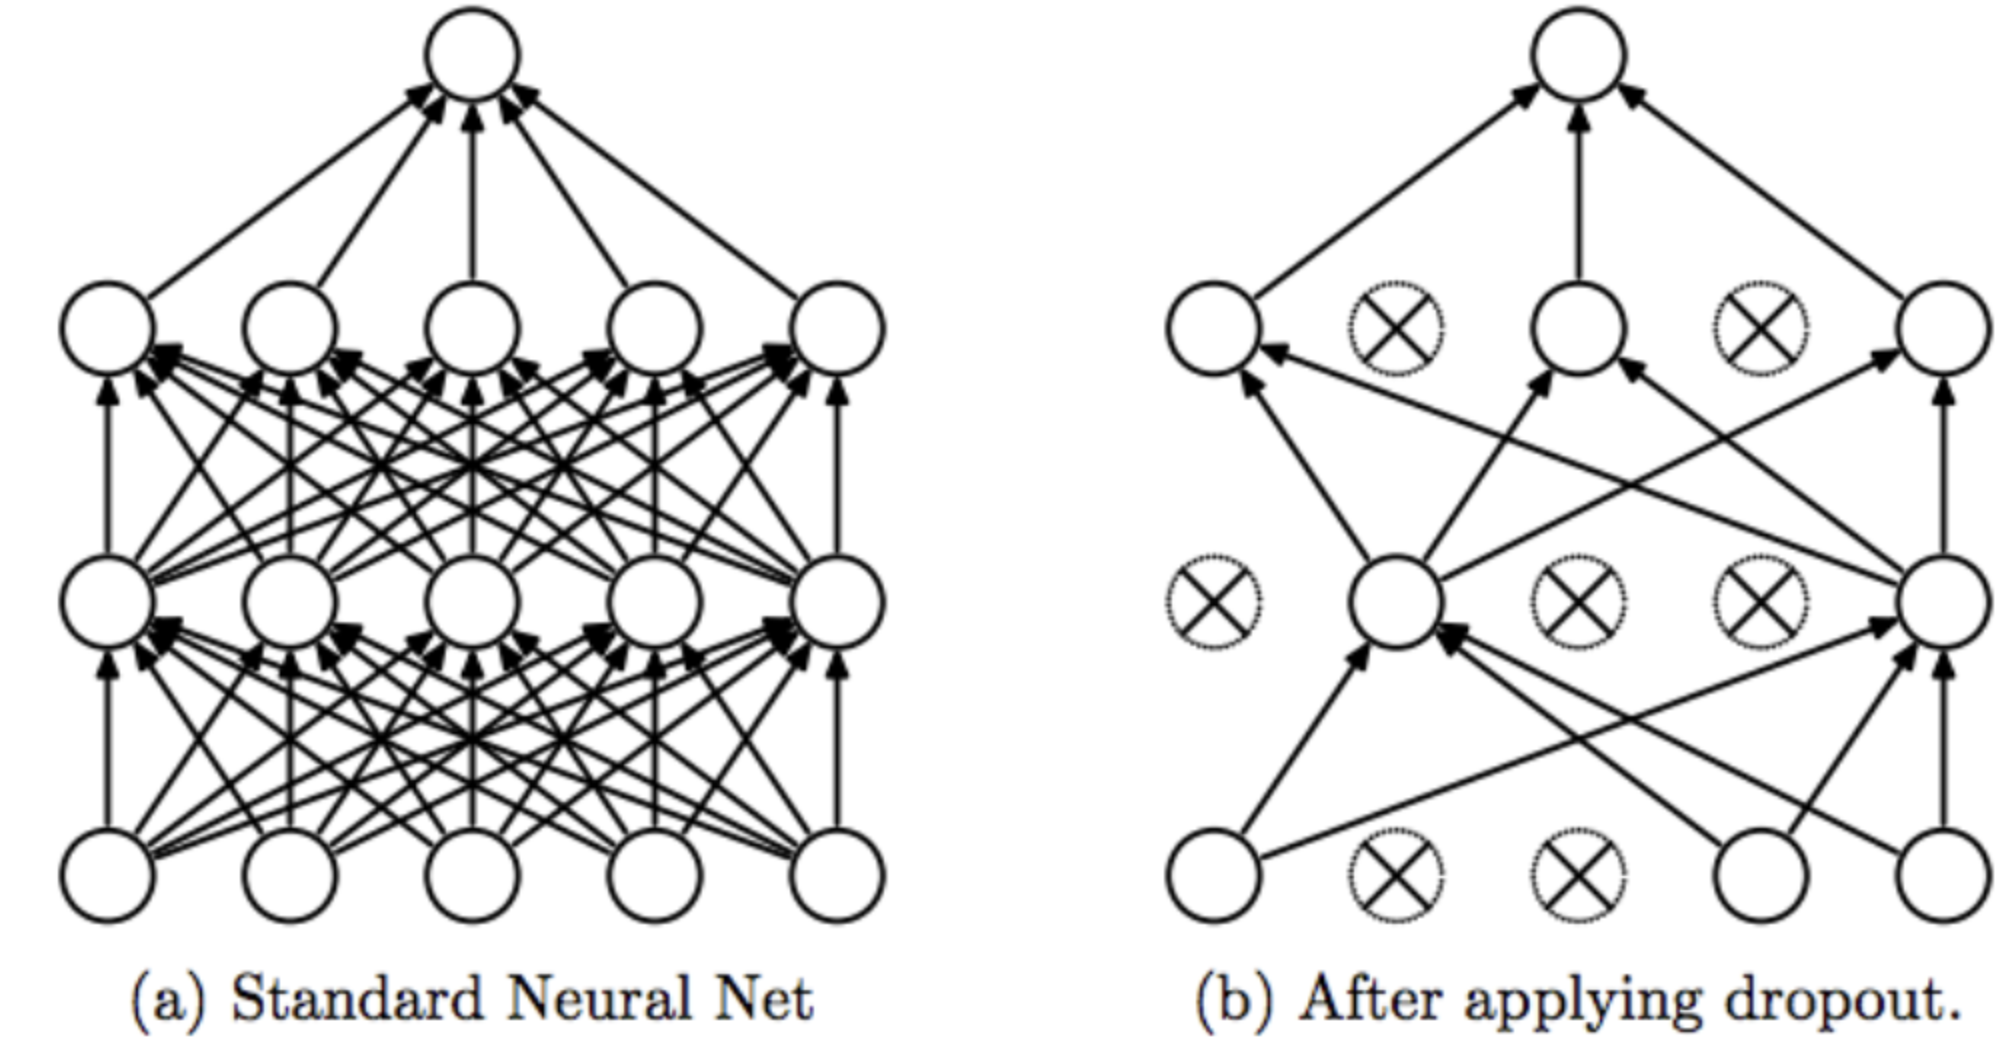

Pytorch provides a builting dropout layer. To use it, all that is needed is to provide it a probability of dropping a node. The higher the probability the more likely a node will be dropped during training. It is important to remember to use the `train()` and `eval()` function to delineate between when the model is training and testing as the dropout layer will behave differently.

In [ ]:
class DropoutModel(torch.nn.Module):

  def __init__(self, p):
      super().__init__()

      self.input_layer = torch.nn.Linear(1, 10)
      self.dropout = torch.nn.Dropout(p=p)
      self.output_layer = torch.nn.Linear(10,1)

  def forward(self, input_values):
      input_values = self.input_layer(input_values).relu()
      input_values = self.dropout(input_values)
      return self.output_layer(input_values)

network = DropoutModel(0.5)
network.train()
# --- do training ---
network.eval()
# --- do evaluation and inferencing ---

DropoutModel(
  (input_layer): Linear(in_features=1, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)

## **Early Stopping**
The idea behind early stopping is to combine the training loss along with the validation loss to reduce overtraining. To do this
- A portion of the training data is held out as a validation set.
- The backpropagation is done only on the non-validation set.
- The error of the model on the validation set is monitored.
- The training stops once the validation error no longer decreases.

In [ ]:
# --- general imports ---
from typing import Callable
import numpy as np
# --- torch imports ---
import torch


class EarlyStopping:
    """
    A class to allow monitoring of model's validation accuracy during training.

    Notes:
        Early stopping during training is one technique to prevent over-fitting of a model.
    """

    def __init__(self,
                 patience: int,
                 checkpoint_path: str,
                 minimum_improvement: float = 0.0,
                 verbose: bool = False,
                 trace_function: Callable = print):
        """
        Args:
            patience: The number of iterations to wait for improvement before early stopping.
            checkpoint_path: The path in which to save the model state.
            minimum_improvement: The minimum change in monitored quantity to qualify as an improvement.
            verbose: Whether to log the improvements for each checkpoint.
            trace_function: Logging function.
        """
        # ---  set the properties ---
        self.patience = patience
        self.checkpoint_path = checkpoint_path
        self.minimum_improvement = minimum_improvement
        self.verbose = verbose
        self.trace_function = trace_function

        # --- initialize the tracking quantities ---
        self.counter = 0
        self.best_score = None
        self.validation_loss_minimum = np.Inf
        self.stop = False

    def __call__(self, model: torch.nn.Module, validation_loss: float):

        if self.best_score is None:
            self.best_score = validation_loss
            self.save_checkpoint(model, validation_loss)
        elif validation_loss > self.best_score - self.minimum_improvement:
            self.counter += 1
            if self.verbose:
                self.trace_function(f"Early Stopping Counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.stop = True
        else:
            self.best_score = validation_loss
            self.save_checkpoint(model, validation_loss)
            self.counter = 0

    def save_checkpoint(self, model: torch.nn.Module, validation_loss: float):
        """Saves the Model.

        Args:
            model: The model to save
            validation_loss: The loss of the validation dataset.
        """
        if self.verbose:
            self.trace_function(f"Validation loss: {self.validation_loss_minimum} to {validation_loss}")
        torch.save(model.state_dict(), self.checkpoint_path)
        self.validation_loss_minimum = validation_loss


## **Generalization Training Example**

In this example we will use the MNIST dataset to make a classifier to predict the handwritten number in an image. We will employ dropout and early stopping to ensure our model generalizes

Train Epoch: 0	Train Loss: 0.609837	Validation Loss: 0.266166
Train Epoch: 10	Train Loss: 0.163032	Validation Loss: 0.101341
Train Epoch: 20	Train Loss: 0.114740	Validation Loss: 0.081689
Train Epoch: 30	Train Loss: 0.098754	Validation Loss: 0.072439
Train Epoch: 40	Train Loss: 0.085903	Validation Loss: 0.067549
Train Epoch: 50	Train Loss: 0.077707	Validation Loss: 0.061172
Train Epoch: 60	Train Loss: 0.067913	Validation Loss: 0.065280
Train Epoch: 70	Train Loss: 0.059942	Validation Loss: 0.064731
Stopping training early.


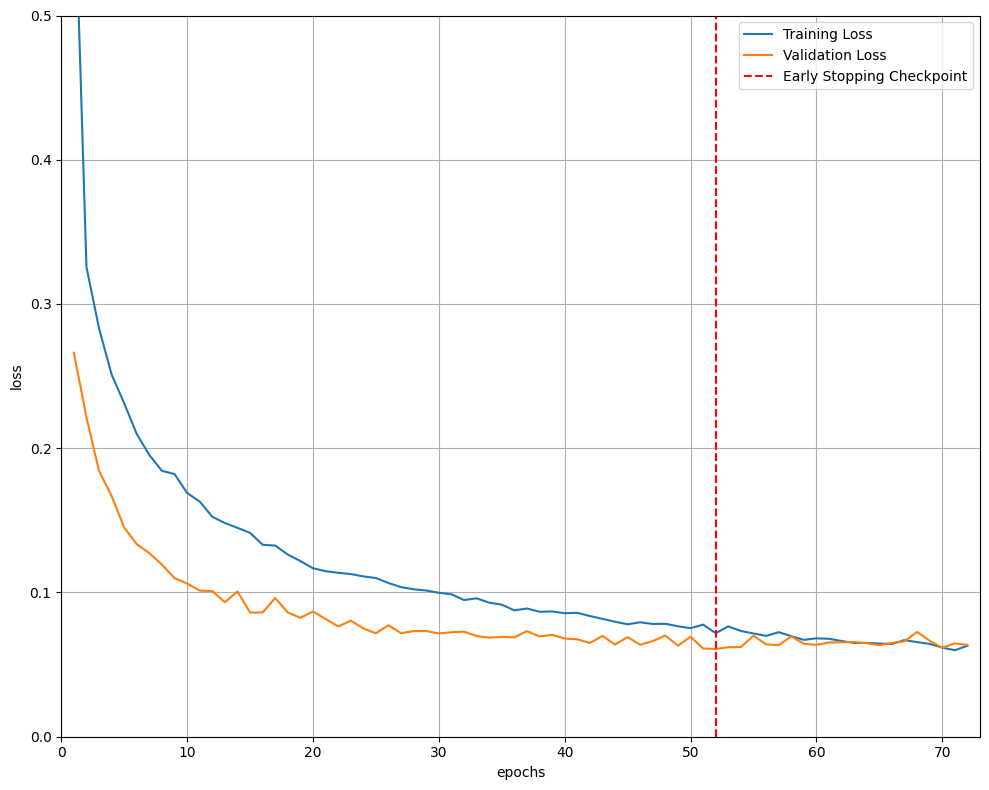


Test set: Average loss: 0.0671, Accuracy: (98.130%)



In [ ]:
# --- general imports ---
import argparse
from typing import Tuple, Optional
# --- torch imports ---
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F


def create_datasets(batch_size: int,
                    validation_percentage: float,
                    root: str,
                    download: bool) -> Tuple[DataLoader, DataLoader, DataLoader]:
    # --- create the transform to tensor ---
    transform = transforms.ToTensor()

    # --- create training data ---
    train_data = datasets.MNIST(root=root, train=True, download=download, transform=transform)

    # --- create test data ---
    test_data = datasets.MNIST(root=root, train=False, download=download, transform=transform)

    # --- create train/validation/test datasets ---
    training_size = len(train_data)
    indices = np.arange(training_size)
    # --- shuffle indices in place ---
    np.random.shuffle(indices)
    # --- split index ---
    training_split = int(np.floor(training_size * validation_percentage))
    train_idx, validation_idx = indices[training_split:], indices[:training_split]

    # --- samplers for batching ---
    train_sampler = SubsetRandomSampler(train_idx)
    validation_sampler = SubsetRandomSampler(validation_idx)

    # --- data loaders ---
    train_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              sampler=train_sampler,
                              num_workers=10)
    validation_loader = DataLoader(train_data,
                                   batch_size=batch_size,
                                   sampler=validation_sampler,
                                   num_workers=10)
    test_loader = DataLoader(test_data,
                             batch_size=batch_size,
                             num_workers=10)

    return train_loader, validation_loader, test_loader


def train_model(input_args,
                model: torch.nn.Module,
                number_of_epochs: int,
                criteria,
                optimizer: torch.optim.Optimizer,
                train_loader: DataLoader,
                validation_loader: DataLoader,
                early_stopping: Optional[EarlyStopping] = None):
    # --- setup tracking losses over epochs ---
    average_train_losses = []
    average_validation_losses = []

    # --- iterate over epochs ---
    for epoch in range(number_of_epochs):

        # --- perform training ---
        model.train()
        train_losses = []
        for data, target in train_loader:
            # --- clear the gradients ---
            optimizer.zero_grad()
            # --- forward pass ---
            output = model(data)
            # --- compute the loss ---
            loss = criteria(output, target)
            # --- perform backward pass ---
            loss.backward()
            # --- optimization step ---
            optimizer.step()
            # --- update train losses ---
            train_losses.append(loss.item())

        # --- perform validation over the batches ---
        model.eval()
        validation_losses = []
        for data, target in validation_loader:
            # --- forward pass ---
            output = model(data)
            # --- compute the loss ---
            loss = criteria(output, target)
            # --- update the validation losses ---
            validation_losses.append(loss.item())

        # --- compute average losses over the batches ---
        train_loss = np.mean(train_losses)
        validation_loss = np.mean(validation_losses)
        average_train_losses.append(train_loss)
        average_validation_losses.append(validation_loss)

        # --- early stopping ---
        if early_stopping is not None:
            early_stopping(model, validation_loss)
            if early_stopping.stop:
                print("Stopping training early.")
                break
        # --- log the training stats ---
        if epoch % input_args.log_interval == 0:
            print('Train Epoch: {}\tTrain Loss: {:.6f}\tValidation Loss: {:.6f}'.format(
                epoch, train_loss, validation_loss))

        # --- stop training in first epoch if dry run ---
        if input_args.dry_run:
            break

    # --- recover the model if using early stopping ---
    if early_stopping is not None:
        model.load_state_dict(torch.load(early_stopping.checkpoint_path))

    return model, average_train_losses, average_validation_losses


def model_test(model, criteria, test_loader: DataLoader):
    # --- prep the test metrics ---
    test_losses = []
    correct = 0
    model.eval()
    number_of_evals = 0

    with torch.no_grad():
        # --- test the samples ---
        for data, target in test_loader:
            output = model(data)
            test_losses.append(criteria(output, target).item())
            prediction = output.argmax(dim=-1)
            equate = prediction.eq(target.view_as(prediction)).squeeze()
            number_of_evals += len(equate)
            correct += equate.sum().item()

    return np.mean(test_losses), correct / number_of_evals


class Net(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 10)
        self.dropout1 = torch.nn.Dropout(p=0.4)
        self.dropout2 = torch.nn.Dropout(p=0.5)

    def forward(self, x: torch.Tensor):
        x = x.view(-1, 28 * 28)
        x = F.elu(self.fc1(x))
        x = self.dropout1(x)
        x = F.elu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        output = F.log_softmax(x, -1)
        return output

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        output = self(x)
        output = torch.argmax(output, -1)
        return output



# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=256, metavar='N',
                    help='input batch size for training (default: 256)')
parser.add_argument('--test-batch-size', type=int, default=256, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=100, metavar='N',
                    help='number of epochs to train (default: 100)')
parser.add_argument('--validation_percent', type=float, default=0.1,
                    help='Percentage of training data to use for validation (default: 0.1)')
parser.add_argument('--dataset_path', type=str, default="./",
                    help='Path of the MNIST dataset')
parser.add_argument('--download_dataset', action='store_true', default=True,
                    help='Allows for downloading the MNIST dataset.')
parser.add_argument('--model_path', type=str, default="./",
                    help='Path of the folder in which to save/load the model')

# --- early stopping ---
parser.add_argument('--use_early_stopping', action='store_false', default=True,
                    help='Disables early stopping.')
parser.add_argument('--es_patience', type=int, default=20,
                    help='The maximum number of epochs to wait for improvements before early stopping.')

parser.add_argument('--dry-run', action='store_true', default=False,
                    help='quickly check a single pass')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_false', default=True,
                    help='For Saving the current Model')
args = parser.parse_args([])

# --- setup the paths ---
model_path_check_point = args.model_path + "/model_checkpoint.pt"
final_model_path = args.model_path + "/final_model.pt"

# --- create the dataset loaders ---
train_lder, valid_lder, test_lder = create_datasets(args.batch_size,
                                                    args.validation_percent,
                                                    args.dataset_path,
                                                    args.download_dataset)

# --- set up the training problem ---
network = Net()
opt = torch.optim.Adam(network.parameters())

loss_fn = torch.nn.CrossEntropyLoss()

# --- setup early stopping ---
es = None
if args.use_early_stopping:
    es = EarlyStopping(args.es_patience, model_path_check_point)

# --- train the model ---
output_model, train_lss, valid_lss = train_model(args,
                                                  network,
                                                  args.epochs,
                                                  loss_fn,
                                                  opt,
                                                  train_lder,
                                                  valid_lder,
                                                  es)

# --- visualize the loss as the network trained ---
fig = plt.figure(figsize=(10, 8))
plt.plot(range(1, len(train_lss) + 1), train_lss, label='Training Loss')
plt.plot(range(1, len(valid_lss) + 1), valid_lss, label='Validation Loss')

# --- find position of lowest validation loss ---
model_epoch = valid_lss.index(min(valid_lss))
training_loss = train_lss[model_epoch]
valid_loss = valid_lss[model_epoch]
plt.axvline(model_epoch + 1, linestyle='--', color='r', label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5)  # consistent scale
plt.xlim(0, len(train_lss) + 1)  # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# fig.savefig(args.model_path + 'loss_plot.png', bbox_inches='tight')

# --- test the model ---
test_loss, test_accuracy = model_test(network, loss_fn, test_lder)
print('\nTest set: Average loss: {:.4f}, Accuracy: ({:.3f}%)\n'.format(test_loss, test_accuracy * 100))

# --- save the final model ---
if args.save_model:
    torch.save({"model_state": output_model.state_dict(),
                "training_loss": training_loss,
                "validation_loss": valid_loss,
                "test_loss": test_loss,
                "accuracy": test_accuracy}, final_model_path)


